In [1]:
import torch
torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
torch.cuda.device_count()

1

In [2]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True # set to true once, then back to false after you have created/processed your data unless you want to change something in your training data.


In [ ]:
#creates an array of size 3 and one-hot encodes it at specifies index
a=np.eye(3)[0]
b=np.eye(3)[2]
print(a)
print(b)

[1. 0. 0.]
[0. 0. 1.]


In [ ]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])
                        
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                    
                    except Exception as e:
                        pass
                        #print(label, f, str(e))
        
        np.random.shuffle(self.training_data) #performs in-place shuffling
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [01:24<00:00, 147.61it/s]
C:\Users\shubh\Desktop\Pixsy\ml-retraining\pixsy_work\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats: 12476
Dogs: 12470


In [10]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
training_data = np.load("training_data.npy")

# restore np.load for future normal usage
np.load = np_load_old

print(len(training_data))
print(training_data.shape)
print(training_data[2]) #3rd training example is a cat

24946
(24946, 2)
[array([[ 70,  65,  57, ..., 224, 223, 227],
       [103, 110, 115, ..., 226, 224, 222],
       [130, 139, 145, ..., 226, 228, 229],
       ...,
       [158, 163, 184, ..., 189, 233, 230],
       [120, 141, 151, ..., 184, 231, 230],
       [117, 134, 167, ...,  13, 223, 227]], dtype=uint8)
 array([1., 0.])]


[1. 0.]


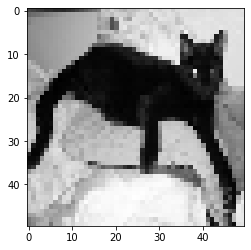

In [11]:
#Now let's take a peak at one of our samples:

import matplotlib.pyplot as plt

plt.imshow(training_data[2][0], cmap="gray")
print(training_data[2][1])

In [6]:
# Building the model
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels i.e number of kernels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #we need to flatten the output of conv layer before feeding into the dense layer. But there exists no .Flatten() func as in tensorflow. So basically we want to know self.fc1 = nn.Linear(????, 512)
        #Let's craete random data and check the output size after passing it through first 3 layers conv layers
        x = torch.randn(50,50).view(-1,1,50,50) #this would be the actual input to our CNN. 1 in 1,50,50 corresponds to the same 1 as in 1,32,5 of first layer of CNN
        self._to_linear = None
        self.convs(x) #calls the conv() func which passing the randomly created data through first 3 layers conv layers and stores output size into _to_linear

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).



    def convs(self, x): # just the forward method but it would run through just the top 3 conv layers and compute the output
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #(2,2) is the shape of pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        #print('Shape is',x[0].shape)
        if self._to_linear is None:
            #typically x will be (batch_size,x,y,z). So x[0] takes the first image of the batch.
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x


    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

net=Net()

In [7]:
net.to(device) #pushes our entire network on the GPU i.e cuda 0. 

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

If we had multiple GPU's we could put our entire training data as well on the other GPU eg cuda1. Here since we have just 1 GPU we will have to put both the model and training data in bactches on the same GPU

In [12]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss() #beacuse the lables here are one-hot encoded

In [13]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [14]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

2494
22452 2494


In [24]:
BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50]
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 225/225 [00:04<00:00, 49.11it/s]


Epoch: 0. Loss: 0.054462507367134094


100%|██████████| 225/225 [00:04<00:00, 50.19it/s]


Epoch: 1. Loss: 0.042431943118572235


100%|██████████| 225/225 [00:04<00:00, 50.09it/s]

Epoch: 2. Loss: 0.038210947066545486


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:05<00:00, 438.72it/s]

Accuracy:  0.767
